# 非均衡分类问题
## 一些概念
* **过拟合（*overfitting*），也称过学习。在一些分类算法中，训练错误率不断下降，但是测试错误率在达到了一个最小值之后又开始上升，这种现象称为过拟合。**


* **正确率（*precision*）:预测为正例的样本数中真正正例的样本数 / 预测正例的样本数**


* **召回率（*recall*）:预测为正例的样本树中的真实正例数 / 真正正例的样本数**


* **非均衡问题：在训练集(Trainingset)中，标签为“1“的类别比例极低。对于分类器不易识别我们想识别的少数数据项。**


* **ROC（*receiver operating characteristic*）曲线，接收者操作特征曲线。 ROC曲线给出的是当阈值变化时假阳率和真阳率的变化情况。**

    **左下角的点所对应的是将所有样例判断为反例的情况，右上角的点对应的是所有样例判为正例的情况。**

    **在理想情况下，最佳的分类器应该在左上角，这样意味着真阳率高，假阳率低。**
    
    **AUC（Area Under the Curve）曲线下的面积，对不同的ROC曲线进行比较的指标。**

### ROC曲线的绘制以及AUC计算

In [1]:
import matplotlib.pyplot as plt
import numpy as np
def plotROC(pred_strengths, class_lables):
    cur = (1.0, 1.0)
    y_sum = 0.0
    num_pos_clas = sum(np.array(class_lables) == 1.0)
    y_step = 1 / float(num_pos_clas)
    x_step = 1 / float(len(class_lables) - num_pos_clas)
    sorted_indic = pred_strengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sorted_indic.tolist()[0]:
        if class_lables[index] == 1.0:
            del_x = 0
            del_y = y_step
        else:
            del_x = x_step
            del_y = 0
            y_sum += cur[1]
        ax.plot([cur[0], cur[0] - del_x], [cur[1], cur[1] - del_y], c='b')
        cur = (cur[0] - del_x, cur[1] - del_y)
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print('the AUC is :', y_sum * x_step)

In [2]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat


def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = np.inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
#                 print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

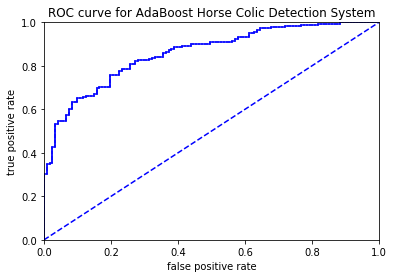

the AUC is : 0.8582969635063604


In [3]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)   #init D to all equal
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
#         print("D:",D.T)
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
#         print("classEst: ",classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
#         print("aggClassEst: ",aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1)))
        errorRate = aggErrors.sum()/m
#         print("total error: ",errorRate)
        if errorRate == 0.0: break
    return weakClassArr, aggClassEst

datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)

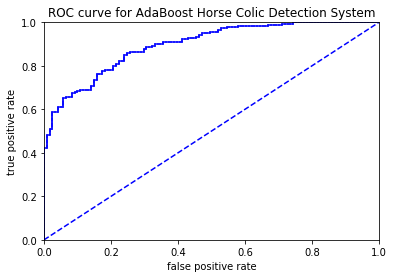

the AUC is : 0.8953941870182941


In [4]:
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 50)
plotROC(aggClassEst.T, labelArr)

## 基于代价函数的分类器决策控制
* **代价敏感学习（cost-sensitive learning）**

 **在分类算法中，我们有很多方法引入代价信息**

    1. 在AdaBoost中，可以基于代价函数来调整错误权重向量D
    
    2. 在朴素贝叶斯中，可以选择最小期望代价而不是最大概率的类别作为最后的结果
    
    3. 在SVM中，可以在代价函数中对于不同类别选择不同的参数c

## 处理非均衡问题的抽样方法
* **欠抽样（undersampling）：删除样例**
* **过抽样（oversampling ）：复制样例**

对于非均衡问题，我们希望罕见类别能尽可能保留更多信息，因此我们应该保留正例类别的所有样例，对反例类别进行欠抽样或者删除处理。

缺点：不确定哪些样例需要删除，且删除样例中可能携带剩余样例中不包含的信息。

解决方法：对距离边界较远的样例进行删除，或者用反例类别的欠正例类别的过抽样相混合的方法，对正例类别复制或者加入插值点，但可能会导致过拟合。